In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [2]:
languages = !ls 'wiki_data/processed/'
languages

['bulgarian(ru).txt',
 'croatian(hr).txt',
 'czech(cs).txt',
 'danish(da).txt',
 'dutch(en).txt',
 'english(en).txt',
 'french(fr).txt',
 'german(de).txt',
 'italian(it).txt',
 'norwegian(da).txt',
 'polish(pl).txt',
 'romanian(ro).txt',
 'serbian(sr).txt',
 'spanish(es).txt',
 'swedish(sv).txt']

Имеем 15 европейских языков в качестве входного алфавита. Запишем их в словарь для дальнейшей удобной работы

In [72]:
%%time
lang_texts = {}

for lang in languages:
    lang_name = lang[:-8]
    with open('wiki_data/processed/' + lang, 'r') as processed_file:
        text = processed_file.read().replace('\n', '').decode('utf-8')
    lang_texts[lang_name] = text

CPU times: user 9.54 s, sys: 7.19 s, total: 16.7 s
Wall time: 19.1 s


In [73]:
print lang_texts['serbian'][:100]

ппјвнппјвнлтнскмрдцмбрјбппддцмбргдндсвјсмртсмтрсзјднгднјспсбнјхппвквлкдсвгпнтфктјвнјпрвбрбсмслмнскмс


In [74]:
# средняя длина текстов
int(np.mean([len(x) for x in lang_texts.values()]))

213124602

У нас в наличии выборка из 15 европейских языков, общая длина текстов каждого языка в среднем 213 миллионов знаков. Из [Предыдущего исследования](Voynich Language Detection.ipynb) видим, что 30000 символов достаточно, чтобы с точностью около 95% определять язык текста. В этом ноутбуке попробуем пойти другим путем. Разобъем наши тексты на фрагменты по `K` символов (дальше выясним, какое `K` является оптимальным для хорошего качества предсказания) и обучим классификатор на векторах N-грам этих фрагментов. Предполагаемый способ может дать возможность определять язык даже для маленьких фрагментов текста (до 100 символов) с большой точностью, а также получится выделить из языков некоторые N-грамы, которые хорошо их описывают.

### Part I: Different alphabets 

In [12]:
def get_text_frames(text, samples_number, frame_len):
    frames = []
    for i in xrange(samples_number):
        cur_index = i * frame_len
        frames.append(text[cur_index:(cur_index + frame_len)])
    return frames

def generate_text_subsamples (lang_samples_num = 5000, frame_len = 100):

    data = pd.DataFrame(columns=['frame', 'lang'])

    for lang in lang_texts:
        frames = get_text_frames(lang_texts[lang], lang_samples_num, frame_len)
        langs = [lang for _ in range(lang_samples_num)]
        data = pd.concat([data, pd.DataFrame({'frame': frames, 'lang': langs})], ignore_index=True)

    return data

In [75]:
%%time
data = generate_text_subsamples()

CPU times: user 91.1 ms, sys: 83.1 ms, total: 174 ms
Wall time: 200 ms


In [86]:
print data.shape
data.head()

(75000, 2)


,frame,lang
0,gtbrgslgrhsgtbrgslgrhsllrfrlgrhstvnlgtvsbnmntl...,swedish
1,sthggtgtbrgfrlgrtvrdtfrststtslglndtchndrktfrgn...,swedish
2,gndhsrbggndnnmrnblndnngvrstrngrfrlgskntrchkltr...,swedish
3,snngrsmdnmrkchnrghdttmtsvrndpplggfrgtbrgsdlskl...,swedish
4,tfrlgrstdnknglggnrltllstrlsntllstrktssmnngmttf...,swedish


Перекодируем целевой признак в целочисленный тип для адеватной работы классификатора (не все умеет обрабатывать категориальные признаки)

In [76]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data.lang = encoder.fit_transform(data.lang)

Отобразим какой в какой лейбел перекодировался каждый язык

In [83]:
set(zip(data.lang.values, encoder.inverse_transform(data.lang)))

{(0, 'bulgarian'),
 (1, 'croatian'),
 (2, 'czech'),
 (3, 'danish'),
 (4, 'dutch'),
 (5, 'english'),
 (6, 'french'),
 (7, 'german'),
 (8, 'italian'),
 (9, 'norwegian'),
 (10, 'polish'),
 (11, 'romanian'),
 (12, 'serbian'),
 (13, 'spanish'),
 (14, 'swedish')}

Разобъем нашу выборку на train и test для обучения модели и предсказания результата соответственно

In [118]:
from sklearn.model_selection import train_test_split

xtr, xcv, ytr, ycv = train_test_split(data.frame, data.lang, test_size = 0.3, random_state = 42)

In [165]:
# На 50k объектах обучаемся, для 22k предсказываем
print xtr.shape
print xcv.shape

(52500,)
(22500,)


Составим разреженную матрицу из н-грам для дальнейшего обучения модели

In [9]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

ngram_vectorizer = CountVectorizer (
    analyzer='char_wb', 
    ngram_range=(3, 4), 
    max_features=200000,
) 

ngram_train = ngram_vectorizer.fit_transform(xtr)
ngram_test = ngram_vectorizer.transform(xcv)

CPU times: user 2.51 ms, sys: 2.54 ms, total: 5.05 ms
Wall time: 7.79 ms


Теперь обучим логистическую регрессию на н-грамах, для мультиклассовой проблемы попробуем использовать One-Vs-Rest и One-Vs-One классификаторы. Посмотрим, какой из них даст лучшие результаты.

#### One-Vs-The-Rest classifier 

In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    penalty='l2',
    dual=True,
    solver='liblinear'
)

from sklearn.multiclass import OneVsRestClassifier
ovr = OneVsRestClassifier(lr)

In [153]:
%%time
ovr.fit(ngram_train, ytr)

CPU times: user 34.1 s, sys: 2.3 s, total: 36.4 s
Wall time: 40.1 s


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [154]:
preds = ovr.predict(ngram_test)

In [157]:
from sklearn.metrics import accuracy_score

accuracy_score(ycv, preds)

0.98133333333333328

#### One-Vs-One classifier  

In [159]:
from sklearn.multiclass import OneVsOneClassifier
ovo = OneVsOneClassifier(lr)

In [160]:
%%time
ovo.fit(ngram_train, ytr)
preds_ovo = ovo.predict(ngram_test)

CPU times: user 23.2 s, sys: 2.14 s, total: 25.3 s
Wall time: 25.7 s


In [161]:
accuracy_score(ycv, preds_ovo)

0.97617777777777781

Получаем, что имея выборку из 50000 фрагментов длины 100 для 15 европейских языков можно с вероятностью `98%` предсказывать язык этого фрагмента на основе его 3- и 4-грам. Попробуем построить зависимость точности предсказания от длины самого фрагмента.

In [166]:
frame_lenghts = [5, 10, 15, 20, 25, 35, 50, 75, 100, 200, 500, 1000]
scores = []

In [167]:
print "Done for (frame length): ",
for frame_len in frame_lenghts:
    sample = generate_text_subsamples(frame_len=frame_len)
    sample.lang = encoder.fit_transform(sample.lang)
    x_tr, x_cv, y_tr, y_cv = train_test_split(sample.frame, sample.lang, test_size = 0.3)
    ngram_tr = ngram_vectorizer.fit_transform(x_tr)
    ngram_te = ngram_vectorizer.transform(x_cv)
    ovr.fit(ngram_tr, y_tr)
    preds_sample = ovr.predict(ngram_te)
    scores.append(accuracy_score(y_cv, preds_sample))
    print frame_len,

Done for (frame length):  5 10 15 20 25 35 50 75 100 200 500 1000


In [266]:
def print_scores(lengths, scores):
    plt.figure(figsize=(15, 6))
    plt.title('Language prediction accuracy score by text frame length')
    plt.xlabel('frame size')
    plt.ylabel('accuracy score')
    plt.plot(lengths, scores)
    plt.show()

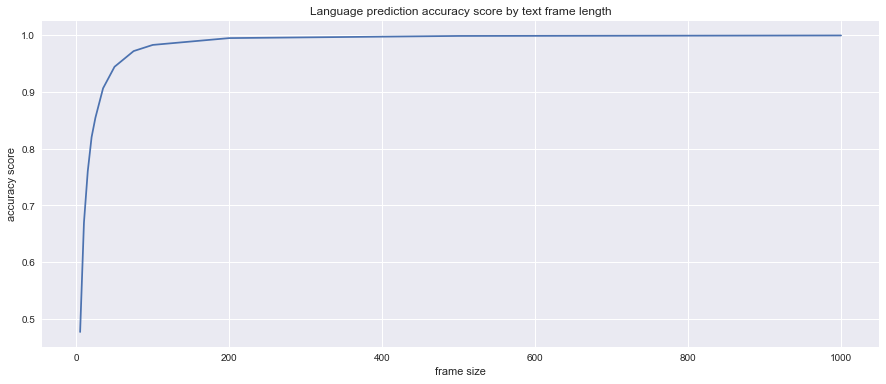

In [267]:
print_scores(frame_lenghts, scores)

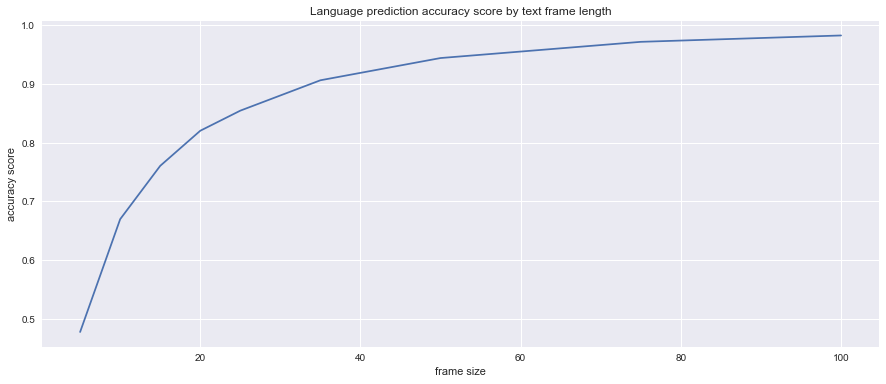

In [268]:
print_scores(frame_lenghts[:-3], scores[:-3])

In [180]:
print 'len\t\tscore\n'
for k, v in zip(frame_lenghts, scores):
    print k, '\t\t', v

len		score

5 		0.477511111111
10 		0.6696
15 		0.760444444444
20 		0.820222222222
25 		0.854444444444
35 		0.906177777778
50 		0.944044444444
75 		0.971644444444
100 		0.982488888889
200 		0.994488888889
500 		0.998266666667
1000 		0.999111111111


Перейдем к наиболее интересной задаче - попробуем различать языки, если бы они были написаны в одном алфавите (латиница). Построим аналогичные графики для этого случая.

### Part II: One latin alphabet 

In [3]:
from textutils import TextProcessor

In [4]:
lang_texts_latin = {}

for lang in languages:
    lang_name = lang[:-8]
    with open('wiki_data/processed/' + lang, 'r') as processed_file:
        text = TextProcessor.get_english_transliteration(
            processed_file.read().replace('\n', '').decode('utf-8')
        )
    lang_texts_latin[lang_name] = text

In [5]:
def generate_english_subsamples (lang_samples_num = 5000, frame_len = 100):

    data = pd.DataFrame(columns=['frame', 'lang'])

    for lang in lang_texts_latin:
        frames = get_text_frames(lang_texts_latin[lang], lang_samples_num, frame_len)
        langs = [lang for _ in range(lang_samples_num)]
        data = pd.concat([data, pd.DataFrame({'frame': frames, 'lang': langs})], ignore_index=True)

    return data

In [6]:
frame_lenghts_latin = [5, 10, 15, 20, 25, 35, 50, 75, 100, 200, 300, 500, 750, 1000]
scores_latin = []

In [193]:
print "Done for (frame length): ",
for frame_len in frame_lenghts_latin:
    sample = generate_english_subsamples(frame_len=frame_len)
    sample.lang = encoder.fit_transform(sample.lang)
    x_tr, x_cv, y_tr, y_cv = train_test_split(sample.frame, sample.lang, test_size = 0.3)
    ngram_tr = ngram_vectorizer.fit_transform(x_tr)
    ngram_te = ngram_vectorizer.transform(x_cv)
    ovr.fit(ngram_tr, y_tr)
    preds_sample = ovr.predict(ngram_te)
    scores_latin.append(accuracy_score(y_cv, preds_sample))
    print frame_len,

Done for (frame length):  5 10 15 20 25 35 50 75 100 200 300 500 750 1000


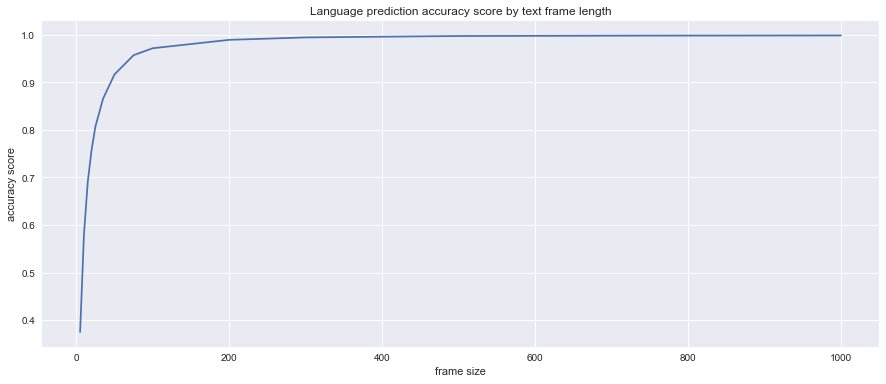

In [269]:
print_scores(frame_lenghts_latin, scores_latin)

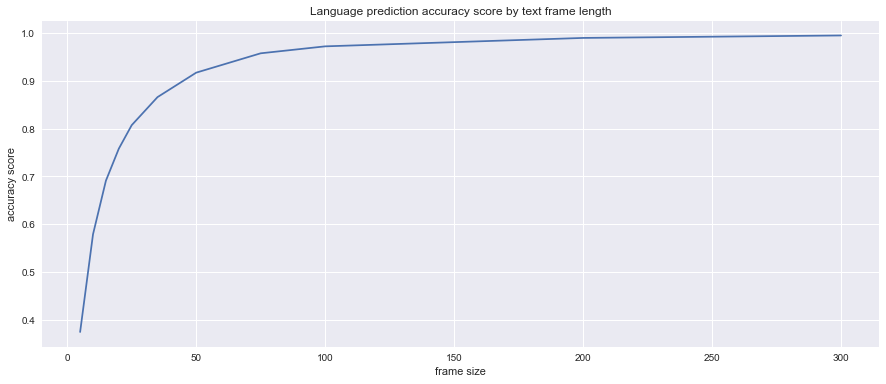

In [270]:
print_scores(frame_lenghts_latin[:-3], scores_latin[:-3])

In [200]:
print 'len\t\tscore\t\t\tscore latin\n'
for k, v1, v2 in zip(frame_lenghts, scores, scores_latin):
    print k, '\t\t', v1, '\t\t', v2

len		score			score latin

5 		0.477511111111 		0.374888888889
10 		0.6696 		0.579111111111
15 		0.760444444444 		0.691155555556
20 		0.820222222222 		0.758044444444
25 		0.854444444444 		0.8072
35 		0.906177777778 		0.865822222222
50 		0.944044444444 		0.916977777778
75 		0.971644444444 		0.957422222222
100 		0.982488888889 		0.971955555556
200 		0.994488888889 		0.989555555556
500 		0.998266666667 		0.994711111111
1000 		0.999111111111 		0.997644444444


### Select K-Best 

Возьмем в качестве образца фреймы длины 100, на выборке с текстами в исходном алфавите качество определения языка для такой длины текстов составляет `0.982`, для текстов в едином алфавите (в латинице) - чуть хуже, `0.971`. Наибольший интерес относительно Манускрипта Войнича составляет выборка текстов в едином алфавите. Количество различных N-грам при этом равно ~125k. 
Интересно проверить, какие именно N-граммы содержат в себе максимум информации о том или ином языке. Попробуем для этого воспользоваться методом K-Best, который позволяет оставить из всей выборки только нужное число признаков сохраняя максимальное количество энтропии системы. Проверим также зависимость числа признаков от качества определения языка.

Генерируем выборку и перекодируем целевой категориальный признак (language) в целочисленный формат

In [13]:
frame_len = 100
sample = generate_english_subsamples(frame_len=frame_len)
sample.lang = encoder.fit_transform(sample.lang)

Векторизуем данные с помощью N-грам. Формат на выходе - разреженная матрица, количество признаков `~125k`

In [16]:
x_tr, x_cv, y_tr, y_cv = train_test_split(sample.frame, sample.lang, test_size = 0.3, random_state = 42)
ngram_tr = ngram_vectorizer.fit_transform(x_tr)
ngram_te = ngram_vectorizer.transform(x_cv)

In [17]:
ngram_tr.shape

(52500, 125789)

Воспользуемся K-Best, для нормальной работы с sparse matricies в задаче классификации рекомендуется использовать критерии `chi2`, или `mutual_info_classif`, хотя со вторым модель работает крайне медленно.

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

Построим зависимость качества предсказания языка от количества лучших выбранных признаков (N-грам)

In [288]:
k_s = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 125000]
scores_k = []

print 'k-best\t\tscore\n'
for k in k_s:
    skb = SelectKBest(chi2, k=k)
    x_tr_kbest = skb.fit_transform(ngram_tr, y_tr)
    x_cv_kbest = skb.transform(ngram_te)
    ovr.fit(x_tr_kbest, y_tr)
    preds_kbest = ovr.predict(x_cv_kbest)
    scores_k.append(accuracy_score(y_cv, preds_kbest))
    print k, '\t\t', scores_k[-1]

k-best		score
10 		0.258577777778
25 		0.380888888889
50 		0.438577777778
100 		0.48
250 		0.711911111111
500 		0.815022222222
1000 		0.884977777778
2500 		0.933911111111
5000 		0.949866666667
10000 		0.962711111111
25000 		0.969022222222
50000 		0.970577777778
100000 		0.971111111111
125000 		0.9712


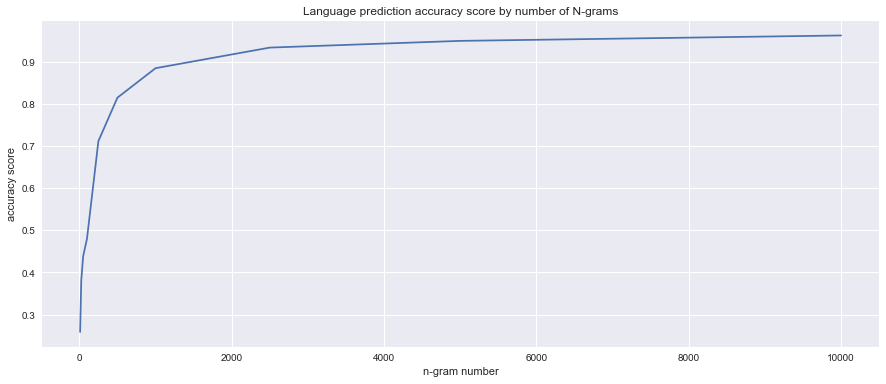

In [292]:
plt.figure(figsize=(15, 6))
plt.title('Language prediction accuracy score by number of N-grams')
plt.xlabel('n-gram number')
plt.ylabel('accuracy score')
plt.plot(k_s[:-4], scores_k[:-4])
plt.show()

Посмотрим глазами на эти N-граммы. Отобразим первые K тех, которые считались "лучшими". Посмотрим также, какие именно языки эти N-грамы описывают лучше всего.

In [ ]:
from sklearn import preprocessing

frames_grouped_by_lang = sample.groupby(by='lang', as_index=False).frame.sum()
ngram_grouped = ngram_vectorizer.transform(frames_grouped_by_lang.frame)

feature_scores = sorted (
    zip([i for i in range(len(skb.scores_))], skb.scores_),
    key=lambda x: x[1],
    reverse=True
)

In [93]:
def get_ngram_lang(n_gram):
    data_col_idx = ngram_vectorizer.vocabulary_[n_gram]
    lang_ngram_counts = ngram_grouped.getcol(data_col_idx).data
    ngram_counts_scaled = preprocessing.scale(lang_ngram_counts)
    lang_label_max = np.argmax(np.abs(ngram_counts_scaled))
    return encoder.classes_[lang_label_max]

def print_k_best(k = 10):
    print 'N-gram\t\tLanguage\t\tScore\n'
    for _k in range(k):
        feature_name = ngram_vectorizer.get_feature_names()[feature_scores[_k][0]]
        feature_score = feature_scores[_k][1]
        feature_lang = get_ngram_lang(feature_name)
        print feature_name, '\t\t', feature_lang, '\t\t', feature_score

In [95]:
print_k_best(k=20)

N-gram		Language		Score

sch 		german 		38836.3506431
lctr 		romanian 		31061.0611967
dll 		italian 		29764.4322272
ctr 		romanian 		22379.2642959
tncm 		romanian 		22204.5065305
lct 		romanian 		21856.7788511
wrd 		croatian 		21119.9679127
czn 		italian 		20371.5284929
tnc 		romanian 		18659.4226004
ths 		english 		18110.8786345
thr 		english 		17775.9516444
tht 		english 		17708.1793179
blgr 		romanian 		17673.5824438
wdz 		danish 		17409.8626416
chn 		german 		16908.6401484
scw 		dutch 		16859.263593
prz 		polish 		16352.9702822
fth 		english 		15880.6260587
pntr 		romanian 		15404.2819856
rlr 		romanian 		14968.5369053
